In [5]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 10)

In [6]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
download.file(players_url, "players.csv")
players <- read_csv("players.csv")

players_data <- select(players, experience, played_hours)

sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
download.file(sessions_url, "sessions.csv")
sessions <- read_csv("sessions.csv")

experience_data <- players_data |>
   mutate(experience_rank = case_when(
       experience == "Veteran" ~ 5,
       experience == "Pro" ~ 4,
       experience == "Regular" ~ 3,
       experience == "Amateur" ~ 2,
       experience == "Beginner" ~ 1,
       TRUE ~ NA_real_)) |>
   filter(played_hours != "0") |>
   select(experience_rank, everything())
experience_data

set.seed(411)
players_split <- initial_split(experience_data, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience_rank,experience,played_hours
<dbl>,<chr>,<dbl>
4,Pro,30.3
5,Veteran,3.8
2,Amateur,0.7
3,Regular,0.1
2,Amateur,0.1
⋮,⋮,⋮
3,Regular,0.1
5,Veteran,0.1
5,Veteran,0.3


In [7]:
set.seed(411)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_recipe <- recipe(played_hours ~ experience_rank, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [ ]:
set.seed(411)
players_gridvals <- tibble(neighbors = seq(1, 50, by = 2))

players_results <- players_workflow |>
   tune_grid(resamples = players_vfold, grid = players_gridvals) |>
   collect_metrics() |>
   filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))
players_min

k_min <- players_min |>
   pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min)|>
  set_engine("kknn") |>
  set_mode("regression")

players_best_fit <- workflow() |>
   add_recipe(players_recipe) |>
   add_model(players_best_spec) |>
   fit(data = players_training)

players_rmse <- players_best_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == "rmse")
players_rmse


.pred,experience_rank,experience,played_hours
<dbl>,<dbl>,<chr>,<dbl>
0.1571429,2,Amateur,0.1
0.1571429,2,Amateur,0.2
0.1571429,2,Amateur,0.1
0.1428571,5,Veteran,0.1
0.1571429,2,Amateur,0.1
⋮,⋮,⋮,⋮
0.2857143,1,Beginner,1.8
0.1428571,5,Veteran,2.7
0.1571429,2,Amateur,2.1


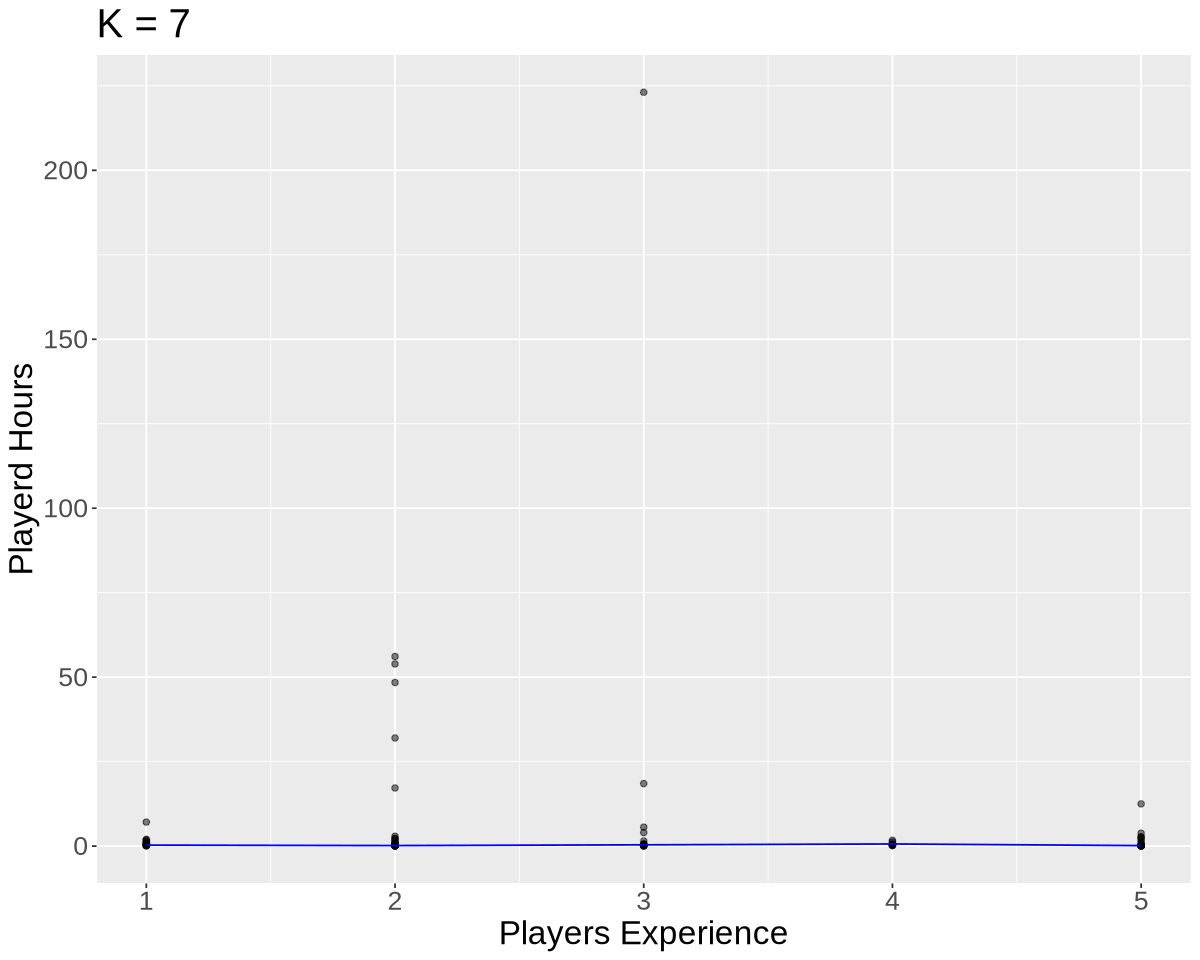

In [11]:
set.seed(411)
options(repr.plot.width = 10, repr.plot.height = 8)

players_preds <- players_best_fit |>
   predict(players_training) |>
   bind_cols(players_training)

players_preds

players_plot <- players_preds |>
  ggplot(aes(x = experience_rank, y = played_hours)) +
  geom_point(alpha = 0.5) +
  geom_line(data = players_preds, mapping = aes(x = experience_rank, y = .pred),
            color = "blue") +
  labs(x = "Players Experience",
       y = "Playerd Hours") +
   ggtitle(paste0("K = ", players_min)) +
  theme(text = element_text(size = 20))

players_plot

## Methods

Players dataset was downloaded and loaded into R and then selected for the specific columns experience and played_hours. The experience column was converted to numerical scaling by ranking them from 1 to 5 using the mutate() function and case_when(). This assigns 5 for "Veteran" and lower values down to 1 for "Beginner". The dataset was then split into training (75%) and testing (25%) subsets with strata = played_hours to ensure the proportion was similar across both splits. KNN regression model was created using recipe(), KNN model spec, v-fold cross validation on the training set for a grid of values for K, workflow combining recipe and KNN model, and filtering to find the best setting for number of neighbors with the minimum RMSE. After, the KNN model was retrained and fit using a new workflow. Predictions were made for the testing set and calculated the RMSE using metrics() and used the prediction results for training to plot a scatter plot relationship between experience_rank and played_hours.


## Discussion
Results = inconclusive

The KNN regression analysis showed a weak relationship between player experience and hours played as the predictions had very little variation across the experience levels. Many of the data points were concentrated near zero or close to zero played hours across all experience levels which resulted in the predicted values (blue line) remaining relatively flat on the scatterplot. This suggests that player experience is not a strong predictor of played hours due to its weak correlation despite having higher played hours in the dataset. This was expected given that the dataset originally showed many players with little to no hours played across all experiences. Presumably, other factors besides experience alone would be more significant in determining hours played. Therefore, these findings indicate that experience level is not a useful metric for predicting player engagement. Game developers would need to consider additional variables to predict user behaviour effectively as focusing just on experience will lead to inconclusive results/false assumptions about player activity. It leads to future questions about whether other variables would be able to predict played hours better or if larger datasets with longer hours played could improve the model's performance using experience level. How would removing zero-hours played affect the model's accuracy as well.